# Multiple Linear Regression - Raw Features

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats

%matplotlib inline

![mlr](https://miro.medium.com/max/1280/1*lJKFo3yyZaFIx4ET1dLmlg.png)

## Objectives

- Conduct multiple linear regressions in `statsmodels`
- Use standard scaling for linear regression for better interpretation
- Conduct linear regressions in `sklearn`

## Regression with Multiple Predictors

> It's all a bunch of dials

<img width='450px' src='images/dials.png'/>

The main idea here is pretty simple. Whereas, in simple linear regression we took our dependent variable to be a function only of a single independent variable, here we'll be taking the dependent variable to be a function of multiple independent variables.

## Expanding Simple Linear Regression

Our regression equation, then, instead of looking like $\hat{y} = mx + b$, will now look like:

$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1x_1 + ... + \hat{\beta}_nx_n$.

Remember that the hats ( $\hat{}$ ) indicate parameters that are estimated.

Is this still a best-fit *line*? Well, no. What does the graph of, say, z = x + y look like? [Here's](https://academo.org/demos/3d-surface-plotter/) a 3d-plotter. (Of course, once we get x's with subscripts beyond 2 it's going to be very hard to visualize. But in practice linear regressions can make use of dozens or even of hundreds of independent variables!)

## Closed-form Solution

Is it possible to calculate the betas by hand? Yes, a multiple regression problem still has a closed-form solution.

In a word, for a multiple linear regression problem where $X$ is the matrix of independent variable values and $y$ is the vector of dependent variable values, the vector of optimizing regression coefficients $\vec{b}$ is given by:

$\vec{b} = (X^TX)^{-1}X^Ty$.

We'll focus more directly on matrix mathematics later in the course, so don't worry if this equation is opaque to you. See [here](https://stattrek.com/multiple-regression/regression-coefficients.aspx) for a nice explanation and example.

## Confounding Variables

Suppose I have a simple linear regression that models the growth of corn plants as a function of the temperature of the ambient air. And suppose there is a noticeable positive correlation between temperature and plant height.

In [2]:
corn = pd.read_csv('data/corn.csv',
                  usecols=['temp', 'humid', 'height'])

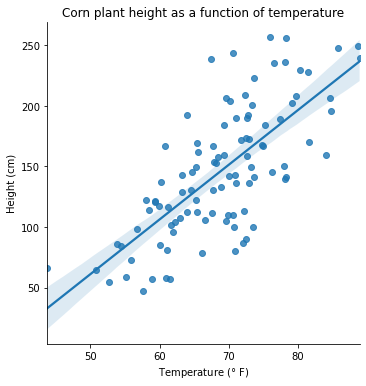

In [3]:
sns.lmplot(data=corn, x='temp', y='height')
plt.xlabel('Temperature ($\degree$ F)')
plt.ylabel('Height (cm)')
plt.title('Corn plant height as a function of temperature');

In [4]:
corn.head()

,temp,humid,height
0,58.086965,49.848304,122.222368
1,70.582087,22.855446,110.079666
2,75.868571,72.856834,256.812528
3,74.732376,38.907566,167.889601
4,77.384666,42.570524,188.914312


It seems that higher temperatures lead to taller corn plants. But it's hard to know for sure. One **confounding variable** might be *humidity*. If we haven't controlled for humidity, then it's difficult to draw conclusions.

One solution is to use **both features** in a single model.

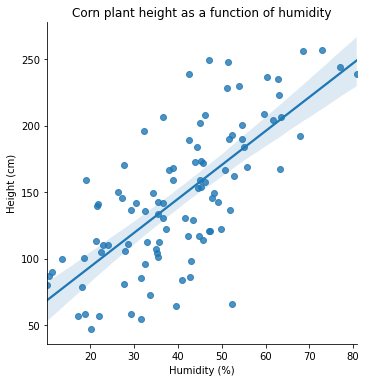

In [5]:
sns.lmplot(data=corn, x='humid', y='height')
plt.xlabel('Humidity (%)')
plt.ylabel('Height (cm)')
plt.title('Corn plant height as a function of humidity');

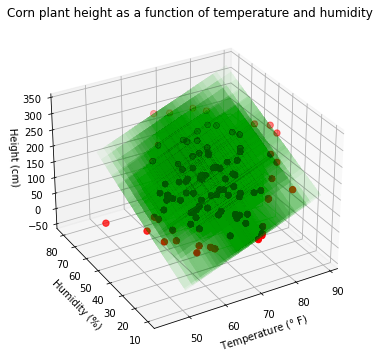

In [6]:
ax = plt.figure(figsize=(8, 6)).add_subplot(111, projection='3d')
ax.scatter(corn['temp'], corn['humid'], corn['height'],
           depthshade=True, s=40, color='#ff0000')
# create x,y
xx, yy = np.meshgrid(corn['temp'], corn['humid'])

# calculate corresponding z
z = 4.3825 * xx + 2.4693 * yy - 255.5434

# plot the surface
ax.plot_surface(xx, yy, z, alpha=0.01, color='#00ff00')

ax.view_init(30, azim=240)
ax.set_xlabel('Temperature ($\degree$ F)')
ax.set_ylabel('Humidity (%)')
ax.set_zlabel('Height (cm)')
plt.title('Corn plant height as a function of temperature and humidity');

One risk we run when adding more predictors to a model is that their correlations with the target may be nearly *collinear* with each other. This can make it difficult to determine which predictor is doing the heavy lifting. We shall explore this theme of **multicollinearity** in more depth in due course.

## Multiple Regression in `statsmodels`

Let's build a multiple regression with `statsmodels`. Let's start with a toy model:

In [7]:
centers = np.arange(1, 6)
preds = np.array([stats.norm(loc=center, scale=3).rvs(200) for center in centers]).T
preds_df = pd.DataFrame(preds, columns=[f'var{center}' for center in centers])

# Here we're setting the target _exactly_ equal to var1 + 2*var2 + 3*var3 + 4*var4 + 5*var5
target = preds_df['var1'] + 2*preds_df['var2'] + 3*preds_df['var3']\
    + 4*preds_df['var4'] + 5*preds_df['var5']
target_df = pd.DataFrame(target, columns=['target'])

In [8]:
df = pd.concat([preds_df, target_df], axis=1)

df.head()

,var1,var2,var3,var4,var5,target
0,7.776969,1.322842,5.739963,2.416490,5.303788,63.827444
1,4.623205,4.223633,4.891570,3.922329,1.595653,51.412763
2,-6.660949,2.210304,5.018547,5.325981,7.763993,72.939185
3,4.576070,5.615830,4.350127,-2.704951,0.705327,21.564943
4,-5.846211,4.644814,6.128121,8.739785,0.331712,58.445478


### Exercise

- Use `statsmodels.OLS()` to fit a linear regression model with five input variables to the target.
- Run the model summary. What are the betas? What value of $R^2$ did you get?

In [13]:
# need to drop the target, otherwise the correlation will be 1, as it's running against itself
x = df.drop('target', axis=1)
# making the target the y, splits this value out, allows us to maintain the values.
y = df['target']

model = sm.OLS(endog=y, exog=sm.add_constant(x)).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.390e+30
Date:                Mon, 07 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:04:03   Log-Likelihood:                 5744.7
No. Observations:                 200   AIC:                        -1.148e+04
Df Residuals:                     194   BIC:                        -1.146e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.281e-13   1.48e-14      8.663      0.000     9.9e-14    1.57e-13
var1           1.0000    1.9e-15   5.26e+14      0.000       1.000       1.000
var2           2.0000   1.83e-15   1.09e+15      0.000       2.000       2.000
var3           3.0000   2.06e-15   1.46e+15      0.000       3.000       3.000
var4           4.0000   1.93e-15   2.07e+15      0.000       4.000       4.000
var5           5.0000   1.89e-15   2.64e+15      0.000       5.000       5.000
==============================================================================
Omnibus:                        1.816   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.403   Jarque-Bera (JB):                1.897
Skew:                          -0.213   Prob(JB):                        0.387
Kurtosis:                       2.787   Cond. No.                         20.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<details>
    <summary>Answer</summary>
<code>X = df.drop('target', axis=1)
y = df['target']
model = sm.OLS(endog=y, exog=X).fit()
model.summary()</code>
    </details>

### Diamonds Dataset

In [10]:
data = sns.load_dataset('diamonds').drop(['cut', 'color', 'clarity'], axis=1)

In [11]:
data.head()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75


In [14]:
x, y = data.drop('price', axis=1), data['price']

In [15]:
model2 = sm.OLS(y, sm.add_constant(x)).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 5.486e+04
Date:                Mon, 07 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:04:10   Log-Likelihood:            -4.7090e+05
No. Observations:               53940   AIC:                         9.418e+05
Df Residuals:                   53933   BIC:                         9.419e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.085e+04    447.562     46.584      0.000       2e+04    2.17e+04
carat       1.069e+04     63.201    169.085      0.000    1.06e+04    1.08e+04
depth       -203.1541      5.504    -36.910      0.000    -213.942    -192.366
table       -102.4457      3.084    -33.216      0.000    -108.491     -96.401
x          -1315.6678     43.070    -30.547      0.000   -1400.086   -1231.250
y             66.3216     25.523      2.599      0.009      16.296     116.347
z             41.6277     44.305      0.940      0.347     -45.210     128.465
==============================================================================
Omnibus:                    14093.399   Durbin-Watson:                   1.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           373568.966
Skew:                           0.674   Prob(JB):                         0.00
Kurtosis:                      15.822   Cond. No.                     5.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<details>
    <summary><b>Remember that $R^2$ can be negative!</b> Click here for code that demonstrates this.</summary>

<code>bad_pred = np.mean(y) * np.ones(len(y))
worse_pred = (np.mean(y) + 1000) * np.ones(len(y))
print(metrics.r2_score(y, bad_pred))
print(metrics.r2_score(y, worse_pred))</code>
    </details>

Negative Rsquared is BAD! If you're seeing this, then you need to FIX SOMETHING

## Wine Dataset 🍷

This dataset includes measurable attributes of different wines as well as their rated quality.

In [16]:
wine = pd.read_csv('data/wine.csv')

wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [17]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  red_wine              6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


In [18]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red_wine
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


Imagine we want to attempt to estimate the perceived quality of a wine using these attributes.

In [19]:
wine['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [20]:
wine['red_wine'].value_counts()

0    4898
1    1599
Name: red_wine, dtype: int64

### 🧠 **Knowledge Check**

> Why are we using "quality" as the dependent variable (target)? Would it make sense for another feature to be the target instead?

## Running the Regression

First, we'll separate the data into our predictors (X) and target (y)

In [21]:
wine_x = wine.drop('quality', axis=1)
#dropped the target from the dataset for the sake of eliminating the perfect correlation between the target regressed w/against itself
wine_y = wine['quality']
wine_x.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1


Now we can perform our (multiple) linear regression!

### Adding an Intercept ("Bias", "Constant") Term

When we were looking at *simple* linear regression, we generally assumed that there would be an intercept term ($\beta_0$) as well as a slope term ($\beta_1$). That will be no less true for multiple linear regression. So this time let's add an intercept term. We can do that by simply adding a column of ones to our dataset, and `statsmodels` has a shortcut for that.

In [22]:
# use sm.add_constant() to add constant term/y-intercept
predictors = sm.add_constant(wine_x)
predictors

,const,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red_wine
0,1.0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1
1,1.0,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,1
2,1.0,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,1
3,1.0,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,1
4,1.0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,1.0,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,0
6493,1.0,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0
6494,1.0,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,0
6495,1.0,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,0


#### Example:
- Lowercase sm.ols, will calculate the constant for us AND we will feed the formula into the function
    - need to create a formula ('quality' ~ [each independent/predictor/x-value or variable])
- Uppercase is MUCH more inline with what we will do with stats models

In [23]:
model = sm.OLS(wine_y, predictors).fit()

> All right! So we fitted our model! Take a look at the summary and look if you can understand the different parts.

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     227.8
Date:                Mon, 07 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:17:01   Log-Likelihood:                -7195.2
No. Observations:                6497   AIC:                         1.442e+04
Df Residuals:                    6484   BIC:                         1.450e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  104.3904     14.105      7.401      0.000      76.741     132.040
fixed acidity            0.0851      0.016      5.396      0.000       0.054       0.116
volatile acidity        -1.4924      0.081    -18.345      0.000      -1.652      -1.333
citric acid             -0.0626      0.080     -0.786      0.432      -0.219       0.094
residual sugar           0.0624      0.006     10.522      0.000       0.051       0.074
chlorides               -0.7573      0.334     -2.264      0.024      -1.413      -0.102
free sulfur dioxide      0.0049      0.001      6.443      0.000       0.003       0.006
total sulfur dioxide    -0.0014      0.000     -4.333      0.000      -0.002      -0.001
density               -103.9096     14.336     -7.248      0.000    -132.013     -75.806
pH                       0.4988      0.091      5.506      0.000       0.321       0.676
sulphates                0.7217      0.076      9.466      0.000       0.572       0.871
alcohol                  0.2227      0.018     12.320      0.000       0.187       0.258
red_wine                 0.3613      0.057      6.367      0.000       0.250       0.473
==============================================================================
Omnibus:                      140.992   Durbin-Watson:                   1.648
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              313.985
Skew:                           0.016   Prob(JB):                     6.59e-69
Kurtosis:                       4.077   Cond. No.                     2.96e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.96e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Interpretation:

- density appears to have the greatest affect on quality, as it has the LARGEST coefficient (regardless of neg or pos)

HOWEVER:
- an x value change of 1 unit would change the overall quality score by a factor of 103 - which is not actually real, as you see below. A unit change of 1 falls outside the range of possibilities for that column total.

In [25]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red_wine
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


SO - We need to scale the data in order to compare accurately. 
- to do that, we'll scale each columns' values against the std of each column respectively, thus putting each of it's values into a unit of std

# Scaling - The Missing & Helpful Step

When you looked at the summary after we did the linear regression, you might have noticed something interesting.

Observing the coefficients, you might notice there are two relatively large coefficients and only one other is greater than 1.

## What's Going on Here?

In a word, it's useful to have all of our variables be on the same scale, so that the resulting coefficients are easier to interpret. If the scales of the variables are very different one from another, then some of the coefficients may end up on very large or very tiny scales.

This happens since the coefficients will effectively attempt to "shrink" or "expand" the features before factoring their importance to the model.

![](images/shrinkinator.jpeg)

This can make it more difficult for interpretation and identifying coefficients with the most "effect" on the prediction.

For more on this, see [this post](https://stats.stackexchange.com/questions/32649/some-of-my-predictors-are-on-very-different-scales-do-i-need-to-transform-them).

## A Solution: Standard Scaling

One solution is to *scale* our features. There are a few ways to do this but we'll focus on **standard scaling**.

When we do **standard scaling**, we're really scaling it to be the features' respective $z$-scores.

Benefits:

- This tends to make values relatively small (mean value is at $0$ and one standard deviation $\sigma$ from the mean is $1$).
- Easier interpretation: larger coefficients tend to be more influential

### Interpretation of Coefficients

Let's take a moment on this last point. Recall our interpretation of the linear regression coefficients (or betas): Suppose the coefficient for some predictor $x_1$ in a linear model is $\beta_1$. That's then to say that for a one-unit increase in the value of $x_1$, the model predicts an increase in the target of $\beta_1$ units.

But let's now focus on this idea of *units*. Suppose I build a model of liver tumor size (mm) that includes body mass (kg) and fingernail length ($\mu$m) as predictive features. And suppose further that the coefficients I find after fitting the model are:

- body mass: 0.1
- fingernail length: 0.1

Now: Which variable is more important to predicting liver tumor size? The coefficients have the same value, but they have very different interpretations in this context. The first coefficient tells us that, for every *kilogram* increase of body mass, I should expect an increase in liver tumor size of 0.1 mm. The second coefficient tells us that, for every *micron* increase of fingernal length, I should expect an increase in liver tumor size of 0.1 mm. Since microns are so small, fingernail length is likely more important than body mass.

Another thing to keep in mind here is that scaling recasts the values of a variable in terms of that variable's *standard deviation*. And so variables with greater spreads of values will typically be more important than variables with smaller spreads. (A variable with no spread can't explain much of anything!)

We can remove much of the guess work about which variables are more important by standardizing, since that **puts all variables on the same scale and in units of their standard deviations**.

We just have to remember to keep in mind this transformation when *interpreting* our coefficients. So suppose our variables' standard deviations are something like

- body mass: 20 kg
- fingernail length: 3000 $\mu$m

And suppose that after scaling we get coefficients that look like this:

- body mass: 2
- fingernail length: 300

Then we can say that for every increase in body mass of 20 kg, we can expect an increase in liver tumor size of 2 mm, and for every increase in fingernail length of 3000 $\mu$m, we can expect an increase in liver tumor size of 300 mm. And now these coefficients are comparable in the sense that they both reflect the variables' underlying spreads and distributions.

For more on this topic, see also [this blog post](https://www.analyticsvidhya.com/blog/2021/03/standardized-vs-unstandardized-regression-coefficient/).

Next time, let's *scale* our columns as $z$-scores first. 

##  Redoing with Standard Scaling

Let's try standard scaling the model with our wine dataset now.

In [26]:
# We'll include all the columns for now.

wine_x_scaled = (wine_x - np.mean(wine_x)) / np.std(wine_x)

In [27]:
wine_x_scaled.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red_wine
count,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03,6497.000000
mean,-3.849639e-16,1.049902e-16,2.187295e-17,3.499672e-17,3.499672e-17,-8.749179e-17,-6.999344e-17,-3.534668e-15,2.729744e-15,-5.424491e-16,9.361622e-16,0.000000
std,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077
min,-2.634589e+00,-1.577330e+00,-2.192833e+00,-1.018034e+00,-1.342639e+00,-1.663583e+00,-1.941780e+00,-2.530192e+00,-3.100615e+00,-2.091935e+00,-2.089350e+00,-0.571367
25%,-6.289329e-01,-6.661613e-01,-4.723335e-01,-7.657978e-01,-5.147986e-01,-7.620742e-01,-6.855323e-01,-7.859527e-01,-6.748622e-01,-6.805919e-01,-8.316152e-01,-0.571367
50%,-1.660892e-01,-3.016939e-01,-5.941375e-02,-5.135612e-01,-2.578826e-01,-8.594301e-02,3.990667e-02,6.448888e-02,-5.287424e-02,-1.429373e-01,-1.608231e-01,-0.571367
75%,3.738951e-01,3.664962e-01,4.911459e-01,5.584445e-01,2.559494e-01,5.901882e-01,7.122647e-01,7.648525e-01,6.313125e-01,4.619241e-01,6.776670e-01,-0.571367
max,6.699425e+00,7.534354e+00,9.231281e+00,1.268682e+01,1.584219e+01,1.456357e+01,5.737257e+00,1.476879e+01,4.923029e+00,9.870879e+00,3.696231e+00,1.750190


In [29]:
wine['fixed acidity'].mean()

7.215307064799139

In [28]:
#this will return us the SAME numbers as above, but the np version is easier to read.
scaler = StandardScaler()
scaler.fit(wine_x)
scaler.transform(wine_x)

array([[ 0.14247327,  2.18883292, -2.19283252, ...,  0.19309677,
        -0.91546416,  1.75018984],
       [ 0.45103572,  3.28223494, -2.19283252, ...,  0.99957862,
        -0.58006813,  1.75018984],
       [ 0.45103572,  2.55330026, -1.91755268, ...,  0.79795816,
        -0.58006813,  1.75018984],
       ...,
       [-0.55179227, -0.6054167 , -0.88525328, ..., -0.47897144,
        -0.91546416, -0.57136659],
       [-1.32319841, -0.30169391, -0.12823371, ..., -1.016626  ,
         1.9354021 , -0.57136659],
       [-0.93749534, -0.78765037,  0.42232597, ..., -1.41986693,
         1.09691202, -0.57136659]])

In [30]:
scaler.mean_

array([7.21530706e+00, 3.39666000e-01, 3.18633215e-01, 5.44323534e+00,
       5.60338618e-02, 3.05253194e+01, 1.15744574e+02, 9.94696634e-01,
       3.21850085e+00, 5.31268278e-01, 1.04918008e+01, 2.46113591e-01])

In [32]:
scaler.scale_

array([1.29633398e+00, 1.64623803e-01, 1.45306681e-01, 4.75743758e+00,
       3.50309051e-02, 1.77480338e+01, 5.65175045e+01, 2.99844222e-03,
       1.60774828e-01, 1.48794421e-01, 1.19261996e+00, 4.30745506e-01])

In [34]:
predictors = sm.add_constant(wine_x_scaled)
model = sm.OLS(wine_y, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     227.8
Date:                Mon, 07 Aug 2023   Prob (F-statistic):               0.00
Time:                        12:42:29   Log-Likelihood:                -7195.2
No. Observations:                6497   AIC:                         1.442e+04
Df Residuals:                    6484   BIC:                         1.450e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.8184      0.009    639.726      0.000       5.801       5.836
fixed acidity            0.1103      0.020      5.396      0.000       0.070       0.150
volatile acidity        -0.2457      0.013    -18.345      0.000      -0.272      -0.219
citric acid             -0.0091      0.012     -0.786      0.432      -0.032       0.014
residual sugar           0.2970      0.028     10.522      0.000       0.242       0.352
chlorides               -0.0265      0.012     -2.264      0.024      -0.049      -0.004
free sulfur dioxide      0.0876      0.014      6.443      0.000       0.061       0.114
total sulfur dioxide    -0.0793      0.018     -4.333      0.000      -0.115      -0.043
density                 -0.3116      0.043     -7.248      0.000      -0.396      -0.227
pH                       0.0802      0.015      5.506      0.000       0.052       0.109
sulphates                0.1074      0.011      9.466      0.000       0.085       0.130
alcohol                  0.2656      0.022     12.320      0.000       0.223       0.308
red_wine                 0.1556      0.024      6.367      0.000       0.108       0.204
==============================================================================
Omnibus:                      140.992   Durbin-Watson:                   1.648
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              313.985
Skew:                           0.016   Prob(JB):                     6.59e-69
Kurtosis:                       4.077   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Compare how well this model did with the one before scaling. Does it perform any differently?

### Notes here
Same R^2, same p-value of the f_statistic, but VERY different coefficient values.


### 🧠 **Knowledge Check**

> After standard scaling, what would it mean when all the $x_i$ are all $0$?
- The means are all 0, as we calculated by standardizing. SO if all x_i's are 0, then we have the mean of the target (or very close to the estimate of the target mean).

> And what does this mean for the constant term $\hat{\beta}_0$? Could we check this?

In [35]:
wine_y.mean()

5.818377712790519

^ NOTE this is very nearly equal to the constant!

REMEMBER the const in this case is the CONSTANT COEFFICIENT - not the constant that we added in order to run the sm.OLS function properly. This additional constant is ALWAYS 1 because regression run against itself will always be equal to itself or 1.